In [82]:
import keras
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.layers import Input, Activation, Dense, Dropout, Flatten, Conv2D,\
                        BatchNormalization, Concatenate, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.utils import plot_model

from src.analysis_tools import plot_confusion_matrix, extract_data
from src.cnn_models import simple_cnn, dense_cnn, coeff_determination, rmse


ImportError: cannot import name 'extract_data'

In [29]:
f = glob('/content/data/*.zip')
extract_data(f[0], '/content/img')

88673581

In [71]:
dates = np.array([f.split('_')[1] for f in glob('/content/img/flowImages/*_m.jpg')])
im_list = np.array((glob('/content/img/flowImages/*_m.jpg')))[np.argsort(dates)]
x = [Image.open(i) for i in im_list]
size = x[0].size
#need to image resize to be consistent
x = np.array([np.array(im.resize(size)) for im in x])
flowdata = pd.read_csv('/content/data/flowData.csv')
#aggregate to the mean flowrate for the day
y = flowdata[flowdata['dates'].isin(dates)].flow.values
#we need another classification of ytrain. Let's just do 2 categories hi vs lo
#print(np.histogram(y, bins=30))
#print(np.median(y),np.mean(y))
#let's just pick the median as the middle point
#threshold = np.median(ytrain)
lower_threshold = np.percentile(y,15)
upper_threshold = np.percentile(y,85)
y_lower = (y<=lower_threshold)
y_mid = ((y>lower_threshold) & (y<upper_threshold))
y_upper = (y>=upper_threshold)
yclass = np.moveaxis(np.array([y_lower, y_mid,y_upper]).astype('int8'), 0,-1)
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.arange(3),
                                                 np.argmax(yclass, axis=1))
print(class_weights)

[2.20679012 0.47858099 2.18654434]


In [72]:
np.random.seed(1234)
i_s = np.random.choice(len(x), len(x), replace=False)
train_perc = 0.8
train_i = i_s[:int(len(x)*train_perc)]
test_i = i_s[int(len(x)*train_perc):]

dates_train = dates[train_i]
dates_test = dates[test_i]
x_train = x[train_i]
x_test = x[test_i]/255.
y_train_flow = y[train_i] 
y_test_flow = y[test_i]
y_train = yclass[train_i]
y_test = yclass[test_i]

input_shape = x.shape[1:]
output_shape = yclass.shape[1]

print(np.bincount(np.argmax(y_train, axis=1)))
print(np.bincount(np.argmax(y_test, axis=1)))

[ 90 392  90]
[ 18 106  19]


In [73]:
shift = 7 
r_range = 5 
batch_size = 8 
brightness_range=(0.8,1)
datagen = ImageDataGenerator(rescale=1./255,\
                             rotation_range=r_range,\
                             width_shift_range=shift,\
                             height_shift_range=shift,\
                             brightness_range=brightness_range)
datagen.fit(x_train, augment=True, seed=1234)

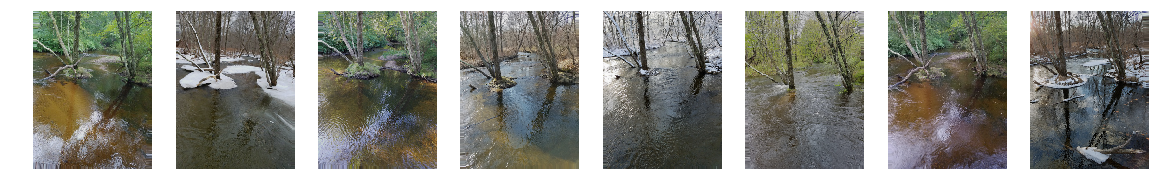

In [74]:
z = next(datagen.flow(x_train,y_train, batch_size))
f, ax = plt.subplots(1,batch_size, figsize=(20,10))
for i in range(batch_size):
    ax[i].imshow(z[0][i])
    ax[i].set_axis_off()

In [75]:
model = dense_cnn(input_shape=input_shape, n_dblocks=3, output_shape=output_shape)
#model = simple_cnn(input_shape=input_shape, output_shape=output_shape)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 500, 375, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 500, 375, 16) 48          input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 500, 375, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 500, 375, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [95]:
opt = Adam(lr=0.0001)
epochs = 5 
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
acc_hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size), \
                               steps_per_epoch=len(x_train)/batch_size, \
                               epochs=epochs, \
                               class_weight=class_weights,\
                               validation_data=(x_test, y_test))

Epoch 1/5
72/71 [==============================] - 51s 707ms/step - loss: 0.4759 - acc: 0.8316 - val_loss: 0.6793 - val_acc: 0.7762
Epoch 2/5
72/71 [==============================] - 49s 686ms/step - loss: 0.4641 - acc: 0.8438 - val_loss: 0.5926 - val_acc: 0.8182
Epoch 3/5
72/71 [==============================] - 49s 686ms/step - loss: 0.4769 - acc: 0.8264 - val_loss: 0.5381 - val_acc: 0.8252
Epoch 4/5
72/71 [==============================] - 50s 688ms/step - loss: 0.4544 - acc: 0.8594 - val_loss: 0.5620 - val_acc: 0.8182
Epoch 5/5
72/71 [==============================] - 50s 689ms/step - loss: 0.4782 - acc: 0.8385 - val_loss: 0.5316 - val_acc: 0.8392


In [96]:
if hist:
    hist_add = acc_hist.history
    for k in hist.keys():
        hist[k].extend(hist_add[k])
else:
    hist = acc_hist.history

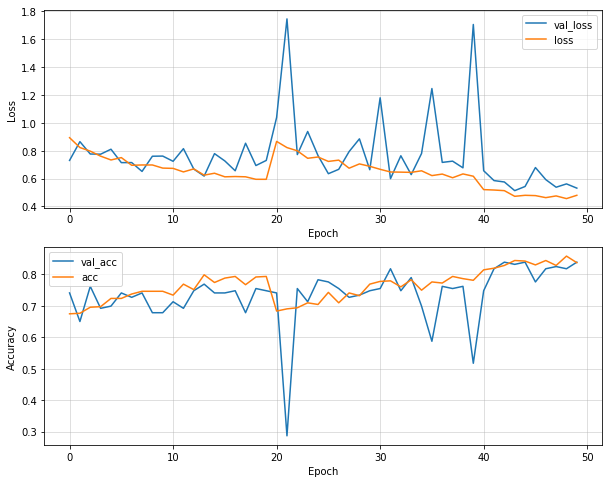

In [98]:
#hist = acc_hist.history
f, ax = plt.subplots(2,1,figsize=(10,8))
for k in hist.keys():
    if 'loss' in k:
        ax[0].plot(hist[k], label=k)
    else:
        ax[1].plot(hist[k], label=k)
ylabels = ['Loss', 'Accuracy']
for i in range(2):
    ax[i].legend()
    ax[i].grid(alpha=0.5)
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlabel('Epoch')
f.savefig('/content/output/accuracy.png', dpi=100, bbox_inches='tight', pad_inches=0)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]


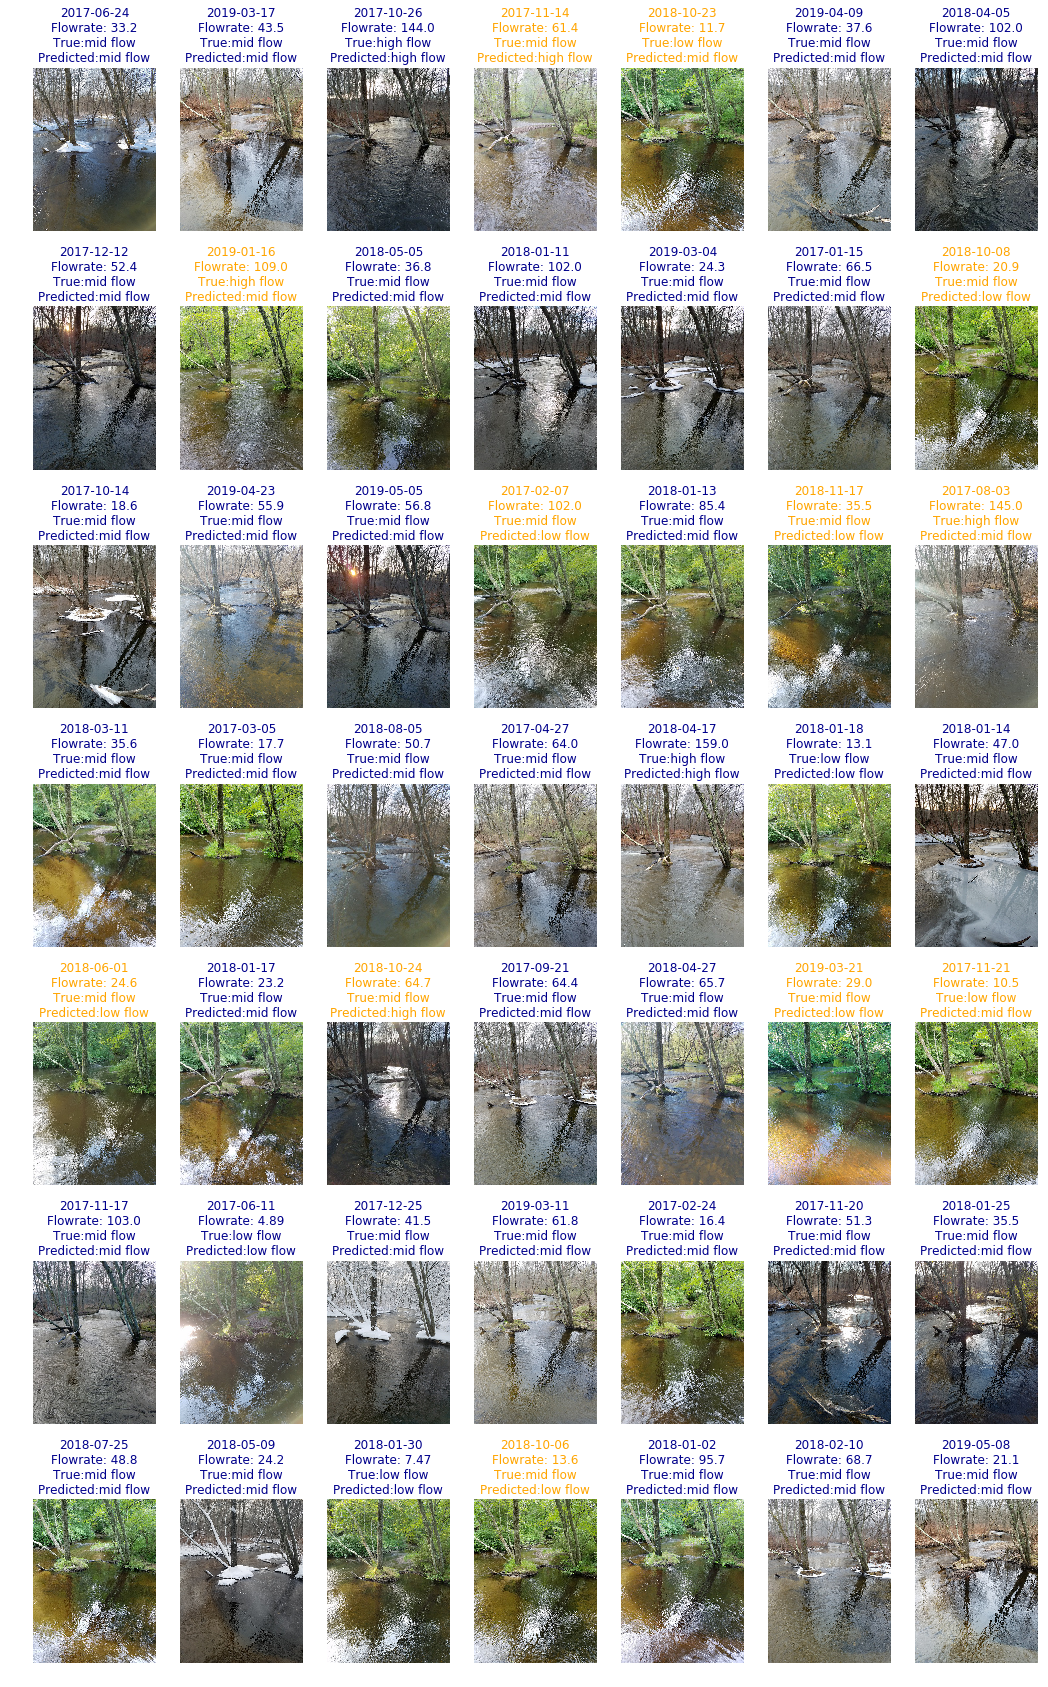

In [99]:
y_hat = model.predict(x_test)
ii = 7 
jj = 7
sample_i = np.random.choice(len(x_test), ii*jj, replace=False).reshape((ii,jj))
label = ['low flow','mid flow','high flow']
color = ['orange', 'darkblue']
f,ax = plt.subplots(ii, jj, figsize=(18,30))
for i in range(ii):
    for j in range(jj):
        s = sample_i[i][j]
        ax[i][j].imshow(x_test[s])
        ax[i][j].set_axis_off()
        ax[i][j].set_title('%s\nFlowrate: %s\nTrue:%s\nPredicted:%s'%(dates_test[s],y_test_flow[s],\
                                             label[np.argmax(y_test[s])],label[np.argmax(y_hat[s])]),\
                                                         color=color[np.argmax(y_test[s])==np.argmax(y_hat[s])])
f.savefig('/content/output/validation.png', dpi=100, bbox_inches='tight', pad_inches=0)

Confusion matrix


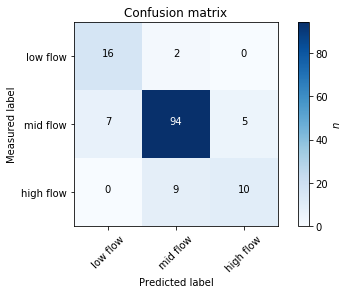

In [100]:
cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_hat,axis=1))
plot_confusion_matrix(cm, classes=label, outname='/content/output/conf_mat.png')

In [101]:
model_json = model.to_json()
with open("/content/output/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/output/model.h5")
print("Saved model to disk")
plot_model(model, to_file='/content/output/model_graph.png')

Saved model to disk
